In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import numpy as np
import json, os, re

from IPython.display import clear_output

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Download the Dataset


In [0]:
!pip install kaggle

#username = "XXXXXXX"  # Insert your username here
#key = "XXXXXX"        # Insert your key here 

api_token = {"username": username,"key": key}

!mkdir /root/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json # that nobody else can read your file

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
os.chdir('/content/pneumonia')
print(os.listdir())
!unzip -q /content/pneumonia/chest-xray-pneumonia.zip
!unzip -q /content/pneumonia/chest_xray.zip

['model_after_10_epochs', 'chest-xray-pneumonia.zip', 'chest_xray.zip', 'chest_xray', '__MACOSX']
replace chest_xray.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace chest_xray/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Creating ImageGenerator instances for training, validating and testing




In [0]:
from pathlib import Path

train_files = "./chest_xray/train/"
test_files = "./chest_xray/test/"
val_files = "./chest_xray/val/"

positive_class_folder_name = "PNEUMONIA"
negative_class_folder_name = "NORMAL"

In [0]:
# training files

# number of X-RAYS which show Pneumonia
P = Path(train_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(train_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Normal - %i " % len(temp))

Training-Pneumonia - 3875 
Training-Normal - 1341 


In [0]:
# testing files

# number of X-RAYS which show Pneumonia
P = Path(test_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(test_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Normal - %i " % len(temp))

Testing-Pneumonia - 390 
Testing-Normal - 234 


In [0]:
# creating ImageDataGenerators for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(featurewise_center = True,
                                     shear_range = 0.2,
                                     rescale = 1.0/255,
                                     horizontal_flip = True,
                                     validation_split = 0.2)

test_generator = ImageDataGenerator(rescale = 1.0/255)

In [0]:
# create batch iterators for the train, validation and test data

train_iterator = train_generator.flow_from_directory(train_files, 
                                                     target_size = (150, 150),
                                                     classes = [positive_class_folder_name, negative_class_folder_name],
                                                     batch_size = 256, 
                                                     shuffle = True, 
                                                     class_mode = "binary",
                                                     subset = "training")
                                                    
validation_iterator = train_generator.flow_from_directory(train_files, 
                                                          target_size = (150, 150),
                                                          classes = [positive_class_folder_name, negative_class_folder_name],
                                                          batch_size = 128, 
                                                          shuffle = False, 
                                                          class_mode = "binary",
                                                          subset = "validation")

test_iterator = test_generator.flow_from_directory(test_files, 
                                                   target_size = (150, 150), 
                                                   classes = [positive_class_folder_name, negative_class_folder_name],
                                                   batch_size = 64, 
                                                   shuffle = False,
                                                   class_mode = "binary")

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### What are the labels?

In [0]:
train_iterator.class_indices

{'NORMAL': 1, 'PNEUMONIA': 0}

### Helper functions

In [0]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

In [0]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        if os.path.isdir(current_directory):
          file_count = len(os.listdir(current_directory))
          subdirectory_names.append(subdirectory)
          subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [0]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

## How many pictures of which class do we have

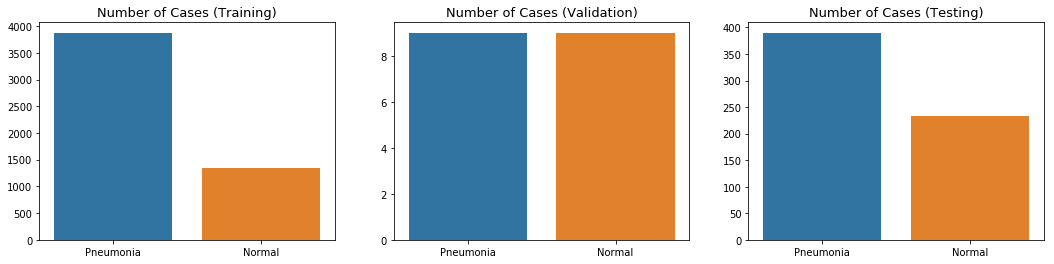

In [0]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(train_files, val_files, test_files, plot_params)
classes = os.listdir(train_files)
classes = [name_correct(i) for i in classes]

In [0]:
# defining category label weights as per imbalance amount of the training dataset

from sklearn.utils.class_weight import compute_class_weight

y = train_iterator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight("balanced", labels, y)
train_class_weights

array([0.67306452, 1.944548  ])

## Transfer Learning using the InceptionV3 pretrained CNN

In [0]:
# are the Colab GPUs available to tensorflow?

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12854248881526848455
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15931972011662589707
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6972708985232691085
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14912199066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9535657115257362993
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
from tensorflow.keras.backend import clear_session

from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization, Dense

from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop, Adam, SGD


## Modify the Inception V3 CNN

### A Model with the RMSprop Optimizer

In [0]:
clear_session()

base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
clear_output()

base_model.trainable = False
myModel = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      #Dense(1024, activation = "relu"),
                      #Dropout(0.3),
                      #Dense(512, activation = "relu"),
                      #Dropout(0.3),
                      #Dense(256, activation = "relu"),
                      Dropout(0.3),
                      Dense(128, activation = "relu"),
                      Dropout(0.3),
                      Dense(1, activation = "sigmoid")])

myModel.compile(RMSprop(), loss = "binary_crossentropy", metrics = ["accuracy"])
myModel.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Tra

### A Model with the Adam Optimizer

In [0]:
clear_session()

lr = 0.00001
#lr = 0.0001
optimizer=Adam(lr=lr)

#optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']


base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
clear_output()

base_model.trainable = False
myModel = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      #Dense(1024, activation = "relu"),
                      #Dropout(0.3),
                      Dense(512, activation = "relu"),
                      Dropout(0.3),
                      #Dense(256, activation = "relu"),
                      #Dropout(0.3),
                      Dense(128, activation = "relu"),
                      #Dropout(0.3),
                      Dense(1, activation = "sigmoid")])

myModel.compile(optimizer=optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 22,917,665
Trainable params: 1,114,881
Non-trainable params: 21,802,784
____________________________________

## Train the model

In [0]:
history = myModel.fit_generator(train_iterator, 
                                steps_per_epoch = len(train_iterator),
                                epochs = 20,
                                verbose = 1,
                                workers = 20,
                                validation_data = validation_iterator, 
                                validation_steps = len(validation_iterator),
                                class_weight = train_class_weights)

Epoch 1/20
17/17 [==============================] - 82s 5s/step - loss: 0.7478 - acc: 0.4488 - val_loss: 1.0417 - val_acc: 0.7392
Epoch 2/20
17/17 [==============================] - 62s 4s/step - loss: 0.6610 - acc: 0.6803 - val_loss: 1.3027 - val_acc: 0.7430
Epoch 3/20
17/17 [==============================] - 55s 3s/step - loss: 0.6276 - acc: 0.7211 - val_loss: 1.2592 - val_acc: 0.7430
Epoch 4/20
17/17 [==============================] - 57s 3s/step - loss: 0.6116 - acc: 0.7290 - val_loss: 1.1624 - val_acc: 0.7430
Epoch 5/20
17/17 [==============================] - 54s 3s/step - loss: 0.5875 - acc: 0.7491 - val_loss: 1.1204 - val_acc: 0.7430
Epoch 6/20
17/17 [==============================] - 53s 3s/step - loss: 0.5577 - acc: 0.7637 - val_loss: 1.1010 - val_acc: 0.7430
Epoch 7/20
17/17 [==============================] - 56s 3s/step - loss: 0.5405 - acc: 0.7711 - val_loss: 1.0829 - val_acc: 0.7430
Epoch 8/20
17/17 [==============================] - 55s 3s/step - loss: 0.5155 - acc: 0.78

## Model Performance Visualization over the Epochs

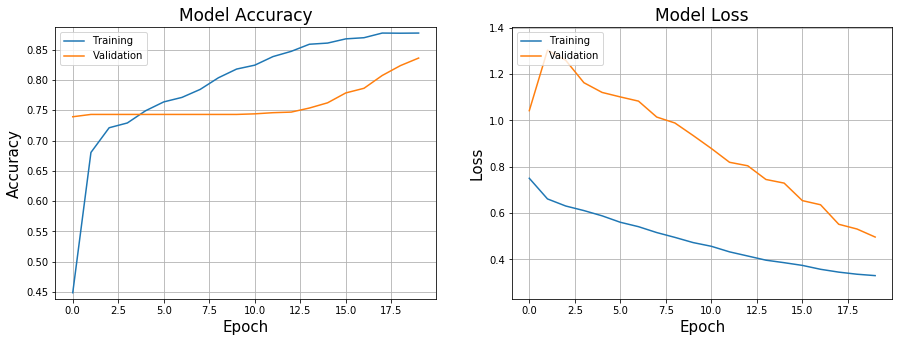

In [0]:
import matplotlib.pyplot as plt

xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

## Save the model

In [0]:
save_model(myModel, "./model_after_10_epochs", overwrite = True, include_optimizer = True)

## Load myModel from local directory if required

In [0]:
myModel = load_model("./model_after_10_epochs")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


##  Compute Evaluation Metrics

In [0]:
from sklearn.metrics import classification_report


yhat = myModel.predict_generator(test_iterator,
                                 steps = len(test_iterator),
                                 verbose = 0)  
mask = yhat > 0.5
yhat[mask] = 1
yhat[~mask] = 0

y = test_iterator.classes

target_names = [positive_class_folder_name, negative_class_folder_name]
print(classification_report(y, yhat, target_names = target_names))

              precision    recall  f1-score   support

   PNEUMONIA       0.64      0.99      0.77       390
      NORMAL       0.74      0.06      0.11       234

    accuracy                           0.64       624
   macro avg       0.69      0.52      0.44       624
weighted avg       0.67      0.64      0.53       624



## Show some test output

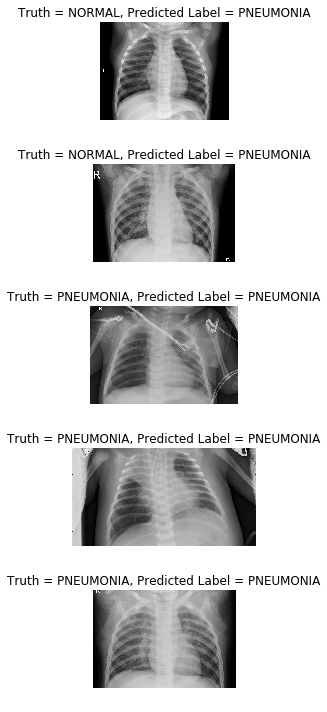

In [0]:
from random import randint
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

label_dict = {0:"PNEUMONIA", 1:"NORMAL"}

test_file_names = test_iterator.filenames
n = len(test_file_names)

plt.rcParams["figure.figsize"] = 12, 10

for i in range(5):
    index = randint(0, n - 1)
    file_name = test_files + test_file_names[index]
    
    image = cv2.imread(file_name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ground_truth_label = label_dict[int(y[index])]
    predicted_label = label_dict[int(yhat[index])]
    
    plt.subplot(5, 1, i + 1)
    plt.axis("off")
    plt.imshow(image)
    
    title = "Truth = " + ground_truth_label + ", Predicted Label = " + predicted_label
    plt.title(title)

plt.tight_layout()
plt.show()